In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn
!pip install networkx
!pip install python-louvain  # This installs the community library which is often used with networkx for community detection


In [5]:
!pip install pandas
!pip install scikit-learn
!pip install gensim
!pip install numpy
!pip install matplotlib

# All the essential imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import gensim.downloader as api
from gensim.models.keyedvectors import KeyedVectors

# Set display options for pandas to avoid scientific notation
pd.set_option('display.float_format', lambda x: f'{int(x)}' if x == int(x) else f'{x:.0f}')

tweet_df_1 = pd.read_csv('/content/drive/MyDrive/Social Network Analysis & GNN/Traditional_ML/downloaded_tweets_extend_nolf2.tsv', sep='\t')
tweet_df_2 = pd.read_csv('/content/drive/MyDrive/Social Network Analysis & GNN/Traditional_ML/downloaded_tweets_extend_original_nolf2.tsv', sep='\t' )

#merging both the dataframe horizontally
merged_tweets = pd.concat([tweet_df_1, tweet_df_2], ignore_index=True).drop(columns=['public_metrics'])
merged_tweets.info()

cleaned_df = merged_tweets.dropna(subset=['in_reply_to_user_id', 'referenced'])
cleaned_df.info()

# categorize author into high influence and low influence
# Authors with that recieved replies & quotes from more than 10 unique users will be considered as high influence
influence_counts = cleaned_df.groupby('author')['in_reply_to_user_id'].nunique()
influence_counts

influence_threshold = 3
influence_counts = influence_counts.reset_index()
influence_counts['influence_category'] = influence_counts['in_reply_to_user_id'].apply(
    lambda x: 'high influence' if x > influence_threshold else 'low influence'
)
# change in_reply_to_user_id to user user count
influence_counts = influence_counts.rename(columns={'in_reply_to_user_id': 'users_replied_quoted'})

# Merge back with the original dataset if needed
cleaned_df_infl_label = pd.merge(
    cleaned_df,
    influence_counts[['author', 'influence_category']],
    on='author',
    how='inner'
)

cleaned_df_infl_label.drop_duplicates()

#group by author based on influence category
cleaned_df_infl_label.groupby('influence_category')['author'].nunique()

cleaned_df_infl_label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106569 entries, 0 to 106568
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   106567 non-null  object 
 1   author               106565 non-null  object 
 2   date                 106564 non-null  object 
 3   hashtags             85914 non-null   object 
 4   referenced           67598 non-null   object 
 5   in_reply_to_user_id  11094 non-null   float64
 6   text_nolf            83490 non-null   object 
dtypes: float64(1), object(6)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 10877 entries, 3 to 106554
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10877 non-null  object 
 1   author               10877 non-null  object 
 2   date                 10877 non-null  object 
 3   hashtags            

,id,author,date,hashtags,referenced,in_reply_to_user_id,text_nolf,influence_category
0,1520168272896962562,308045021,2022-04-29 22:28:54+00:00,"LC,exercise",[<ReferencedTweet id=1520168270283915264 type=...,308045021,Workouts &amp; ample sleep. Sigh….this is grea...,high influence
1,1518605841624190976,308045021,2022-04-25 15:00:21+00:00,"TakingABreak,exercise",[<ReferencedTweet id=1518605836607799296 type=...,308045021,Or will this be me by the end of the week? We’...,high influence
2,1516610008082960389,308045021,2022-04-20 02:49:37+00:00,authenticChineseFood,[<ReferencedTweet id=1516610006992535552 type=...,308045021,"Over cooked. As U can see from my picture, the...",high influence
3,1516601473219629056,308045021,2022-04-20 02:15:42+00:00,MyBigFatGreekWedding,[<ReferencedTweet id=1516408716442038272 type=...,42052422,@NiaVardalos You Persevered ..! #MyBigFatGreek...,high influence
4,1514433241545121793,308045021,2022-04-14 02:39:56+00:00,msm,[<ReferencedTweet id=1514332714379403283 type=...,16129920,"@maddow Texas local news, why aren’t u coverin...",high influence
...,...,...,...,...,...,...,...,...
10872,1520408831880179713,958685436112658432,2022-04-30 14:24:48+00:00,Albo4PM,[<ReferencedTweet id=1520369856071184384 type=...,1238370241169616896,NaN,low influence
10873,1520451336176902150,1170480176,2022-04-30 17:13:41+00:00,"DOG,ScienceResearch",[<ReferencedTweet id=1520450288095797251 type=...,1170480176,NaN,low influence
10874,1520454449583509505,791638976,2022-04-30 17:26:04+00:00,NeverVoteCon,[<ReferencedTweet id=1520452082632900610 type=...,25575859,NaN,low influence
10875,683703028621377537,93193090,2016-01-03 17:34:39+00:00,"ISIS,Ukraine,DonbRRRRRR,Donetsk,novorossia",[<ReferencedTweet id=683694522941964289 type=r...,93193090,NaN,low influence


# Build the Network

In [10]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Assuming 'author_id' and 'in_reply_to_user_id' are the columns denoting interactions
for index, row in cleaned_df.iterrows():
    G.add_edge(row['author'], row['in_reply_to_user_id'])



In [12]:
!pip install python-louvain


In [15]:
import community.community_louvain as community_louvain

# Detect Communities Using Louvain Algorithm

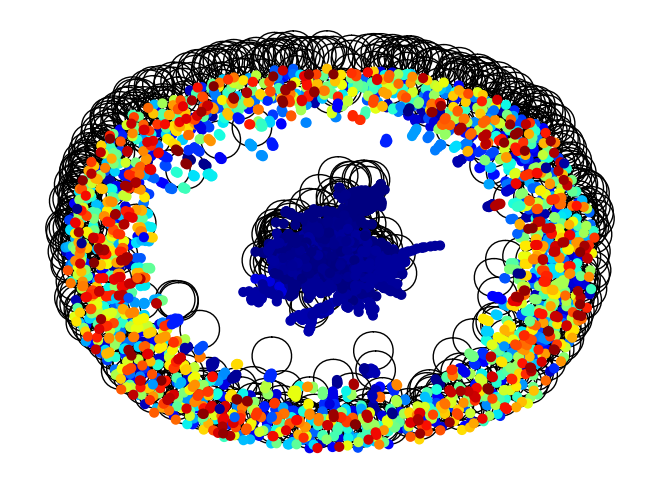

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Detect communities
partition = community_louvain.best_partition(G)

# Add community to the nodes' attributes
nx.set_node_attributes(G, values=partition, name='community')

# Visualize the graph with community layout
pos = nx.spring_layout(G)  # Using a spring layout as fallback
nx.draw(G, pos, node_color=list(partition.values()), node_size=40, cmap=plt.cm.jet)
plt.show()


In [17]:
# Example: Remove one community and analyze changes
removed_nodes = [node for node, comm in partition.items() if comm == 0]  # change '0' to target community number
G.remove_nodes_from(removed_nodes)

# Recalculate metrics such as the number of components, size of the largest component, or other relevant metrics
num_components = nx.number_connected_components(G)
size_largest_component = len(max(nx.connected_components(G), key=len))

print(f"Number of components after removing a community: {num_components}")
print(f"Size of the largest component: {size_largest_component}")


Number of components after removing a community: 1479
Size of the largest component: 5133
